In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [2]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))



In [3]:
data = pd.read_csv("C:\\Users\\Touhe\\TimeSeriesGenerationData_excel.csv", index_col=0,parse_dates=True)

# Drop rows with null values
data = data.dropna()
# Sort the DataFrame by date in ascending order
data = data.sort_index()

# Set the display options to expand all rows
# Use the pd.options.display context manager to show all rows
with pd.option_context('display.max_rows', None):
    print(data)
    


#data.head()

                 DOC
date                
1982-07-29  5.200000
1982-08-31  2.900000
1982-09-24  3.600000
1982-10-22  4.300000
1983-07-25  2.900000
1983-09-02  2.700000
1983-10-04  2.800000
1984-07-25  2.700000
1984-08-23  2.900000
1984-09-21  3.000000
1984-10-21  2.800000
1985-07-23  3.000000
1985-08-20  2.200000
1985-09-23  2.100000
1985-10-27  3.300000
1986-07-16  3.300000
1986-08-12  4.400000
1986-09-11  4.100000
1986-10-23  5.200000
1987-07-31  3.700000
1987-08-30  3.400000
1987-09-29  3.600000
1987-10-29  3.500000
1988-08-07  2.200000
1988-09-04  2.200000
1988-10-01  2.100000
1989-07-11  2.900000
1989-08-06  2.700000
1989-09-30  3.500000
1990-07-01  3.400000
1990-08-04  2.900000
1990-09-02  3.500000
1990-10-05  3.300000
1991-07-09  3.500000
1991-08-10  6.100000
1991-09-09  2.700000
1991-10-07  3.100000
1992-07-07  5.484000
1992-08-04  5.171000
1992-09-02  3.522000
1992-10-06  3.947000
1993-07-13  2.965000
1993-08-10  2.539000
1993-09-01  2.653000
1993-10-04  2.912000
1994-07-07  2

In [4]:
#station = ee.Geometry.Point(-74.86113631486039,43.82283062049295)
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[43.81880036802749, -74.85423940003443], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
def cdom(img):
    co = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b2': img.select('SR_B2'),
        'b3': img.select('SR_B3'),
        'b4': img.select('SR_B4')
    }).rename("CO")
    return img.addBands([co])


In [6]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(cdom)\
   .map(maskL457sr)

#l5 = l5


In [7]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(cdom) \
    .map(maskL8sr)

#l8 = l8


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));




In [8]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('date', img.date().format()).set('mean',mean)

In [9]:
station_reduced_imgs = lall.map(station_mean)


In [10]:
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [11]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date_cdom','mean'])

df

,date_cdom,mean
0,1984-07-03T15:07:36,7.785894
1,1988-06-12T15:09:37,7.738799
2,1988-07-30T15:09:49,7.462581
3,1989-08-18T15:05:40,8.219737
4,1992-05-22T15:02:40,7.919725
...,...,...
183,2022-08-20T15:45:47,8.026488
184,2022-09-21T15:45:54,8.094939
185,2022-11-08T15:45:52,8.017181
186,2022-11-24T15:45:48,9.413884


In [12]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
pd.set_option('display.max_rows', None)

df

,date,mean
0,1984-07-03T15:07:36,7.785894
1,1988-06-12T15:09:37,7.738799
2,1988-07-30T15:09:49,7.462581
3,1989-08-18T15:05:40,8.219737
4,1992-05-22T15:02:40,7.919725
5,1992-07-25T15:01:56,8.069511
6,1994-06-13T14:58:02,7.874092
7,1995-05-31T14:45:55,7.616621
8,1995-06-16T14:45:12,7.828471
9,1999-06-11T15:17:03,7.704234


In [13]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,mean
0,1984-07-03,7.785894
1,1988-06-12,7.738799
2,1988-07-30,7.462581
3,1989-08-18,8.219737
4,1992-05-22,7.919725
5,1992-07-25,8.069511
6,1994-06-13,7.874092
7,1995-05-31,7.616621
8,1995-06-16,7.828471
9,1999-06-11,7.704234


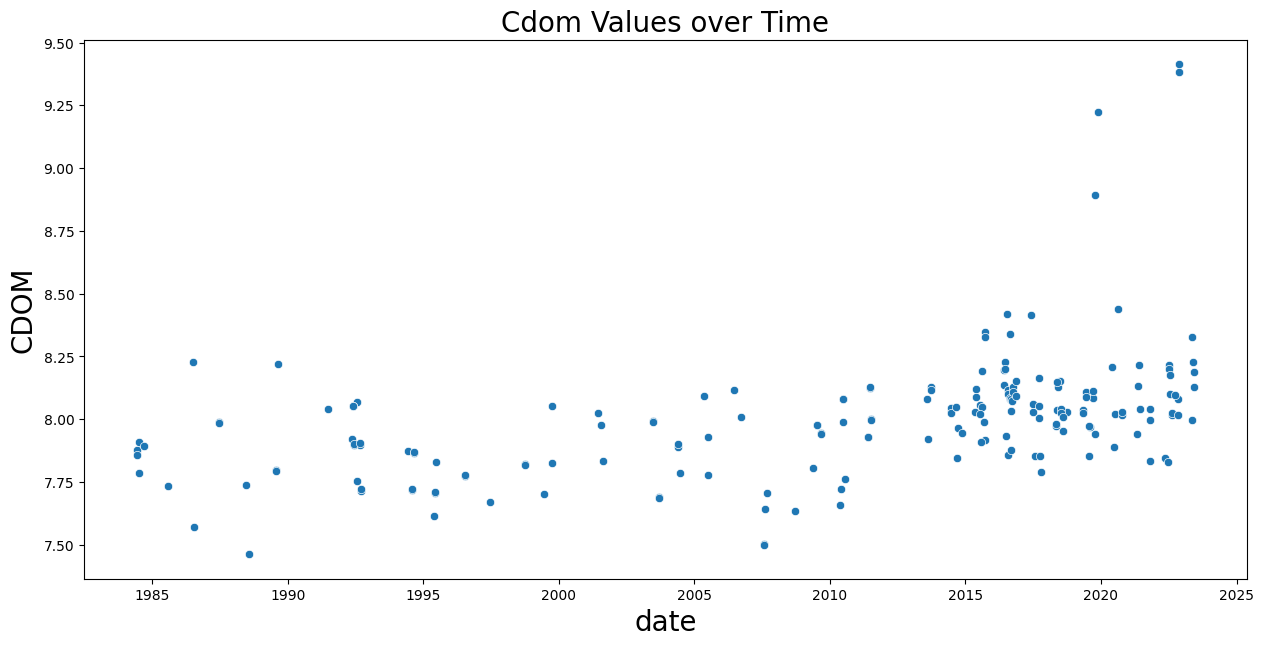

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='mean', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


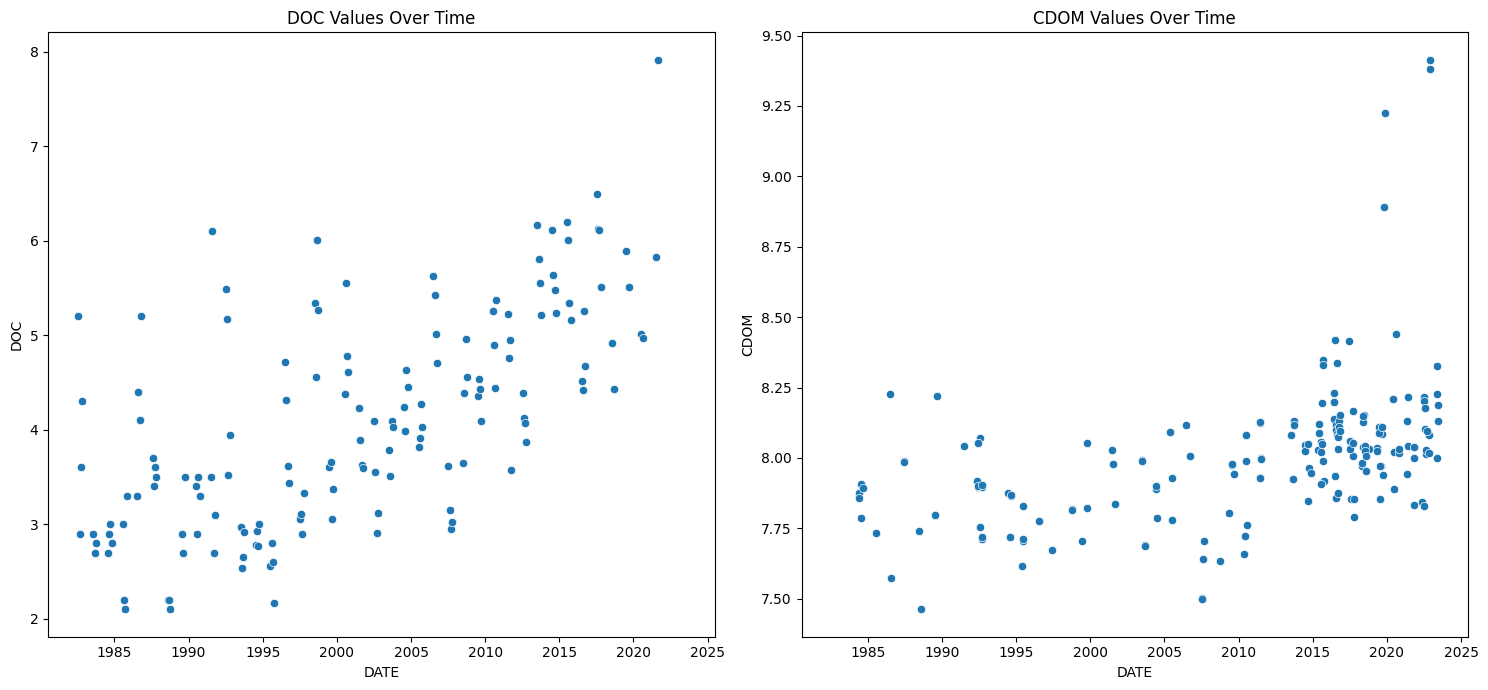

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x=data.index, y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='mean', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


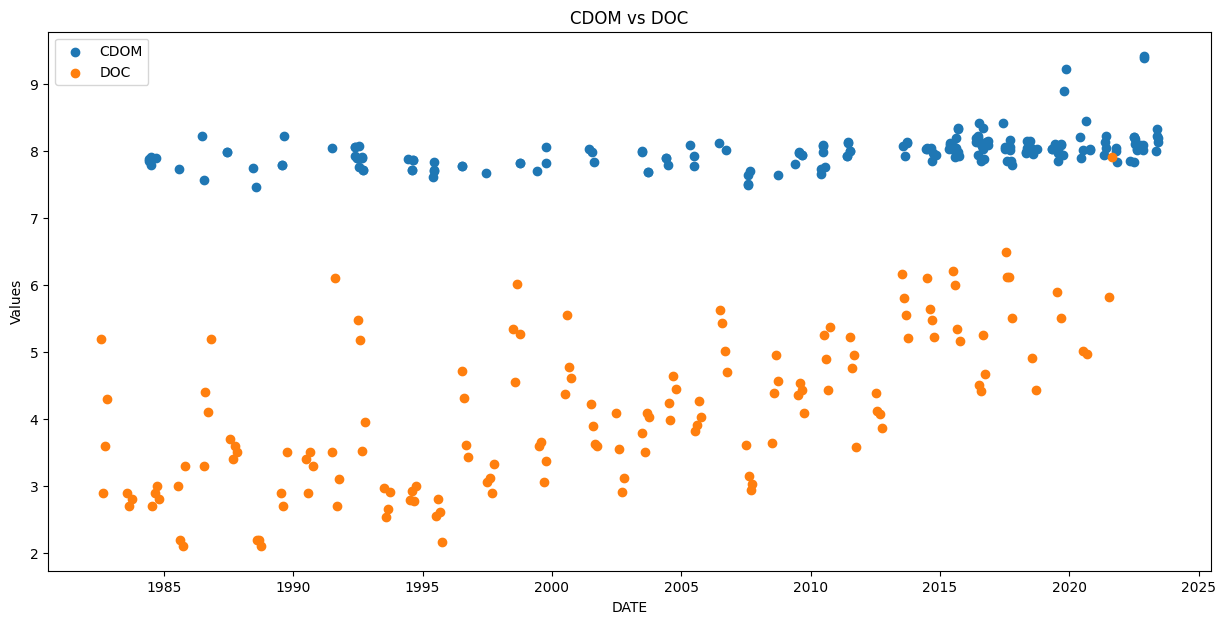

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot
ax.scatter(df['date'], df['mean'], label='CDOM')

# Matplotlib scatter plot
ax.scatter(data.index, data['DOC'], label='DOC')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('Values')
ax.set_title('CDOM vs DOC')

# Add a legend
ax.legend()

# Display the plot
plt.show()


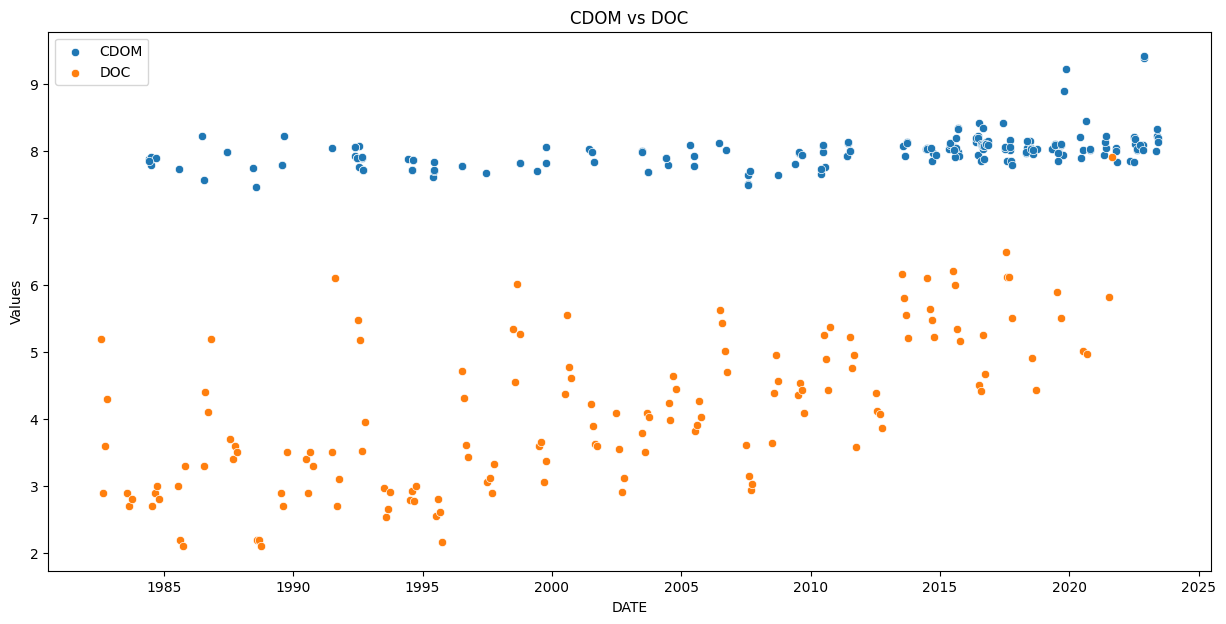

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plots
sns.scatterplot(data=df, x='date', y='mean', ax=ax, label='CDOM')
sns.scatterplot(data=data, x='date', y='DOC', ax=ax, label='DOC')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('Values')
ax.set_title('CDOM vs DOC')

# Add a legend
ax.legend()

# Display the plot
plt.show()


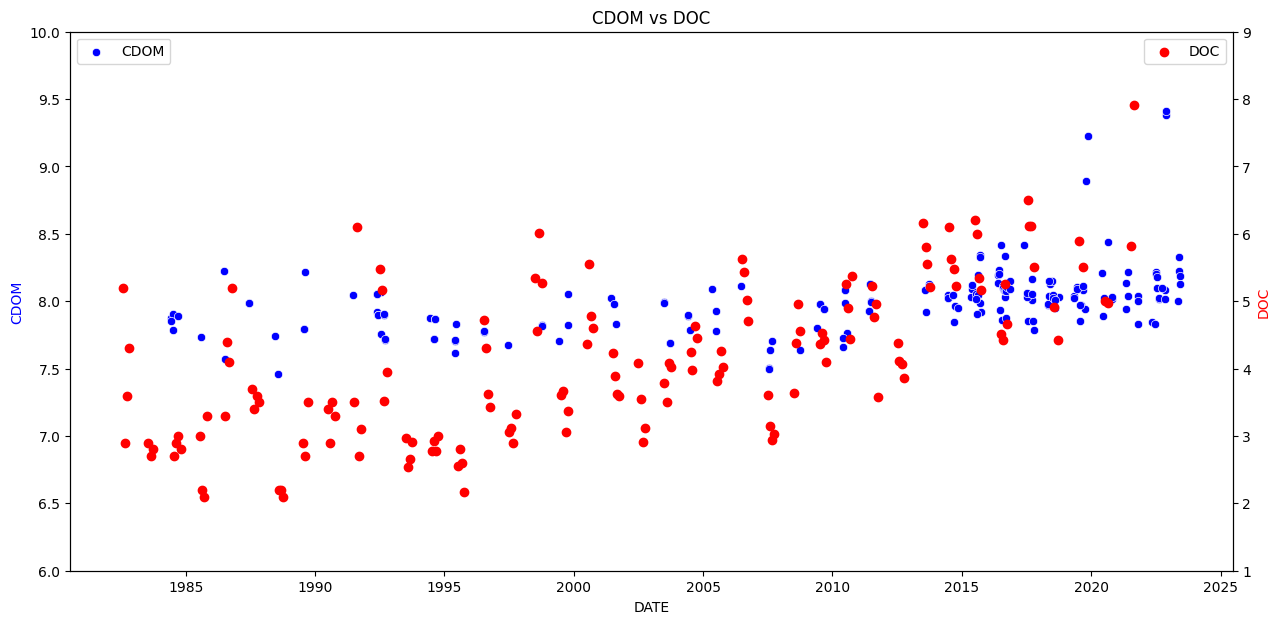

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='mean', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data.index, data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(6, 10)  # Adjust the range for CDOM
ax2.set_ylim(1, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()


In [24]:
import pandas as pd

data = pd.read_csv("C:\\Users\\Touhe\\TimeSeriesGenerationData_excel.csv", index_col=0, parse_dates=True)

# Drop rows with null values
data = data.dropna()
# Sort the DataFrame by date in ascending order
data = data.sort_index()

df = pd.DataFrame(nested_list.getInfo(), columns=['date', 'mean'])

# Convert 'date' column in df to datetime dtype
df['date'] = pd.to_datetime(df['date'])

# Sort the keys in the 'date' column of df in ascending order
df.sort_values('date', inplace=True)


# Perform inner merge with three-day window
merged_inner = pd.merge_asof(df, data, left_on='date', right_index=True, tolerance=pd.Timedelta(days=3))
#merged_inner = merged_inner.dropna()
print(merged_inner)


                   date      mean     DOC
22  1984-06-08 15:13:02  7.877037     NaN
50  1984-06-08 15:13:26  7.856641     NaN
0   1984-07-03 15:07:36  7.785894     NaN
23  1984-07-10 15:13:26  7.907504     NaN
24  1984-09-12 15:14:57  7.892615     NaN
51  1985-07-29 15:15:04  7.733401     NaN
25  1986-06-30 15:08:06  8.226471     NaN
52  1986-07-16 15:07:58  7.571832  3.3000
26  1987-06-17 15:09:28  7.989298     NaN
53  1987-06-17 15:09:52  7.986520     NaN
1   1988-06-12 15:09:37  7.738799     NaN
2   1988-07-30 15:09:49  7.462581     NaN
27  1989-07-24 15:12:03  7.796653     NaN
54  1989-07-24 15:12:27  7.795742     NaN
3   1989-08-18 15:05:40  8.219737     NaN
55  1991-06-28 15:08:21  8.042674     NaN
4   1992-05-22 15:02:40  7.919725     NaN
28  1992-05-29 15:08:25  8.053222     NaN
56  1992-05-29 15:08:49  8.053123     NaN
29  1992-06-14 15:08:13  7.898337     NaN
57  1992-06-14 15:08:37  7.900149     NaN
30  1992-07-16 15:07:50  7.754630     NaN
5   1992-07-25 15:01:56  8.069511 

In [25]:
import pandas as pd

data = pd.read_csv("C:\\Users\\Touhe\\TimeSeriesGenerationData_excel.csv", index_col=0, parse_dates=True)

# Drop rows with null values
data = data.dropna()
# Sort the DataFrame by date in ascending order
data = data.sort_index()

df = pd.DataFrame(nested_list.getInfo(), columns=['date', 'mean'])

# Convert 'date' column in df to datetime dtype
df['date'] = pd.to_datetime(df['date'])

# Sort the keys in the 'date' column of df in ascending order
df.sort_values('date', inplace=True)


# Perform inner merge with three-day window
merged_inner = pd.merge_asof(df, data, left_on='date', right_index=True, tolerance=pd.Timedelta(days=3))

#Get rid of the null values from doc

merged_inner = merged_inner.dropna()
print(merged_inner)


                   date      mean     DOC
52  1986-07-16 15:07:58  7.571832  3.3000
31  1992-09-02 15:07:08  7.895543  3.5220
58  1992-09-02 15:07:32  7.904791  3.5220
36  1996-07-11 14:59:02  7.774886  4.7160
63  1996-07-11 14:59:26  7.777510  4.7160
37  1998-10-05 15:23:41  7.820102  5.2650
65  1998-10-05 15:24:05  7.816302  5.2650
38  1999-10-08 15:21:28  7.823913  3.3690
66  1999-10-08 15:21:52  8.054120  3.3690
122 2016-08-03 15:44:52  8.115334  4.4201
162 2016-08-03 15:45:16  8.099911  4.4201


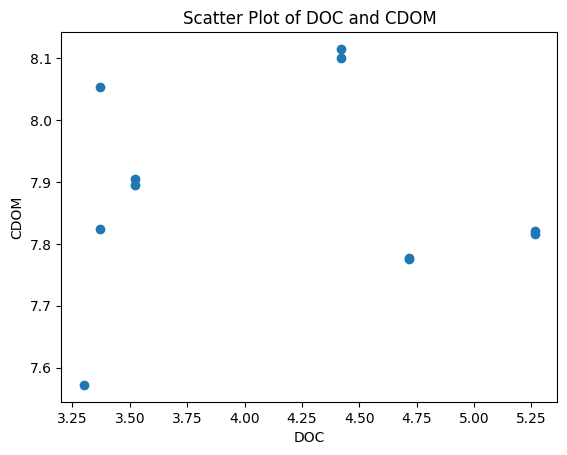

In [26]:
import matplotlib.pyplot as plt

# Plotting the scatter plot
plt.scatter(merged_inner['DOC'], merged_inner['mean'])

# Setting labels and title
plt.xlabel('DOC')
plt.ylabel('CDOM')
plt.title('Scatter Plot of DOC and CDOM')

# Displaying the plot
plt.show()
